# TP 2 : Classification Supervisée
## Algorithmes : KNN, Arbre de Décision et SVM

### Introduction
Ce TP a pour objectif de manipuler trois algorithmes de classification supervisée :
- **KNN (K-Nearest Neighbors)** pour classifier des chiffres manuscrits (dataset MNIST)  
- **Arbre de Décision** pour prédire l'embauche à partir de données simulées  
- **SVM (Support Vector Machine)** pour classifier des données de cancer du sein  

Nous allons suivre les étapes suivantes : chargement des données, préparation, création des modèles, entraînement, évaluation et comparaison des performances.

# Importation des bibliothèques nécessaires :
# - numpy et pandas pour la manipulation des données
# - matplotlib pour l'affichage graphique
# - sklearn pour les algorithmes et métriques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')  # Ignorer les avertissements pour la clarté

# Exercice 1 : KNN
# Importation du dataset MNIST depuis sklearn

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

# Affichage des dimensions des données et des targets

In [3]:
print(f"Shape des données: {mnist.data.shape}")  # Nombre d'exemples et de features
print(f"Shape des targets: {mnist.target.shape}")  # Nombre de labels

Shape des données: (70000, 784)
Shape des targets: (70000,)


# Échantillonnage de 5000 images aléatoires pour accélérer le calcul

In [4]:
sample = np.random.randint(70000, size=5000)
data = mnist.data[sample]
target = mnist.target[sample]

# Division des données en train et test (80%-20%)

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8, random_state=42)

# Recherche du meilleur k pour KNN en testant k de 2 à 15

In [6]:
best_k = 1
best_score = 0

for k in range(2, 16):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    y_pred = knn.predict(xtest)
    score = metrics.accuracy_score(ytest, y_pred)
    
    if score > best_score:
        best_score = score
        best_k = k
    
    print(f"k = {k}, Précision: {score:.4f}")

print(f"\nMeilleur k: {best_k} avec précision: {best_score:.4f}")

k = 2, Précision: 0.9240
k = 3, Précision: 0.9340
k = 4, Précision: 0.9210
k = 5, Précision: 0.9230
k = 6, Précision: 0.9240
k = 7, Précision: 0.9240
k = 8, Précision: 0.9300
k = 9, Précision: 0.9240
k = 10, Précision: 0.9270
k = 11, Précision: 0.9200
k = 12, Précision: 0.9240
k = 13, Précision: 0.9200
k = 14, Précision: 0.9140
k = 15, Précision: 0.9160

Meilleur k: 3 avec précision: 0.9340


# Création du modèle final KNN et prédiction

In [7]:
knn_final = neighbors.KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(xtrain, ytrain)
y_pred_final = knn_final.predict(xtest)
print(f"Précision finale: {metrics.accuracy_score(ytest, y_pred_final):.4f}")

Précision finale: 0.9340


# Affichage de 12 images de test avec leurs prédictions

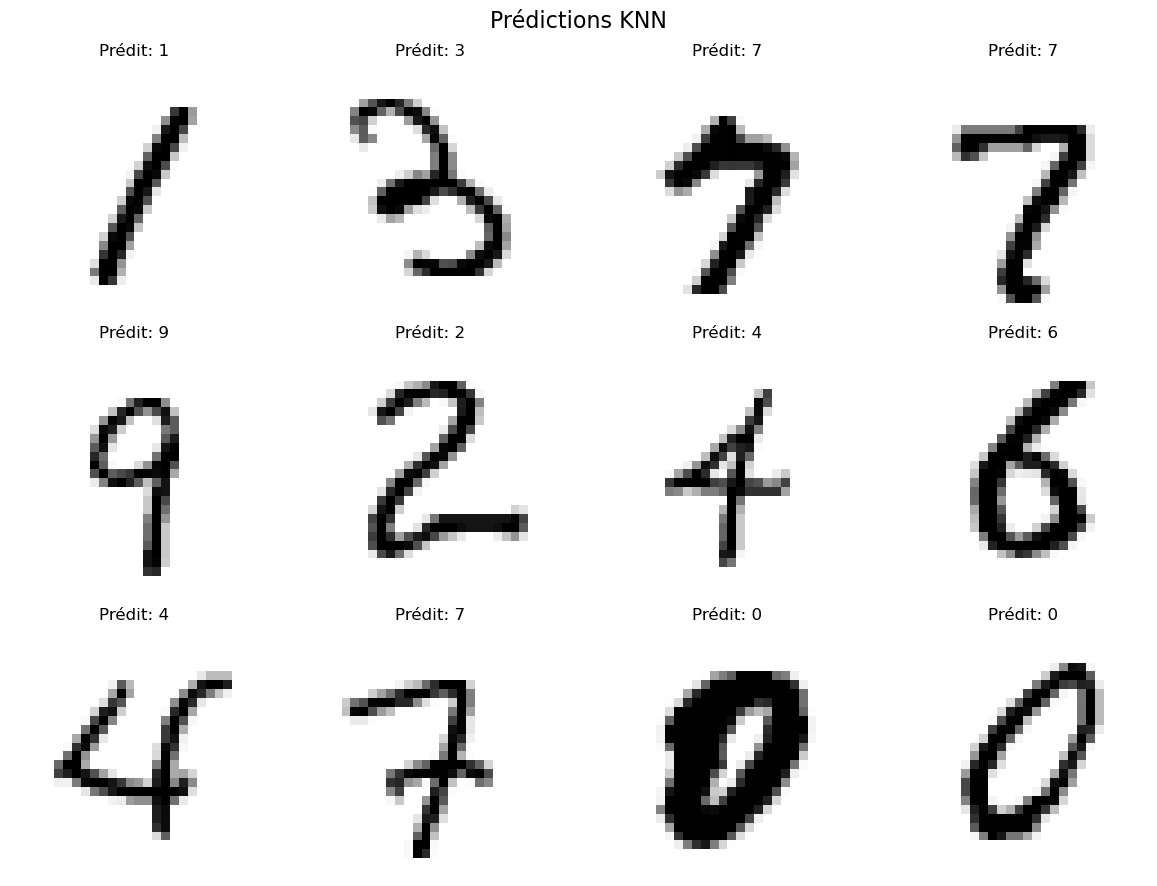

In [8]:
images = xtest.reshape((-1, 28, 28))
select = np.random.randint(images.shape[0], size=12)

fig, ax = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Prédictions KNN', fontsize=16)

for index, value in enumerate(select):
    plt.subplot(3, 4, index+1)
    plt.axis('off')
    plt.imshow(images[value], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title(f'Prédit: {y_pred_final[value]}')

plt.tight_layout()
plt.show()

# Exercice 2 : Arbre de décision
# Création d'un dataset de recrutement simulé

In [9]:
np.random.seed(42)
n_samples = 200

data_recrutement = {
    'Years_Experience': np.random.randint(0, 20, n_samples),
    'Employed': np.random.choice(['Y', 'N'], n_samples),
    'Previous_employers': np.random.randint(0, 10, n_samples),
    'Level_of_Education': np.random.choice(['BS', 'MS', 'PhD'], n_samples),
    'Top_tier_school': np.random.choice(['Y', 'N'], n_samples),
    'Interned': np.random.choice(['Y', 'N'], n_samples),
}

df = pd.DataFrame(data_recrutement)

# Création de la variable cible 'Hired'

In [10]:
hired_conditions = (
    (df['Years_Experience'] > 3) & 
    (df['Employed'] == 'Y') & 
    (df['Level_of_Education'].isin(['MS', 'PhD']))
)
df['Hired'] = np.where(hired_conditions, 'Y', 'N')
print(df.head(10))

   Years_Experience Employed  Previous_employers Level_of_Education  \
0                 6        N                   1                PhD   
1                19        Y                   8                 BS   
2                14        Y                   7                 MS   
3                10        Y                   9                 MS   
4                 7        N                   6                 BS   
5                 6        N                   8                 BS   
6                18        Y                   3                 MS   
7                10        N                   3                PhD   
8                10        Y                   0                 MS   
9                 3        Y                   7                 BS   

  Top_tier_school Interned Hired  
0               Y        N     N  
1               Y        N     N  
2               Y        N     Y  
3               N        Y     Y  
4               N        N     N  
5       

# Encodage des variables catégorielles

In [11]:
mapping_dict = {
    'Employed': {'Y': 1, 'N': 0},
    'Top_tier_school': {'Y': 1, 'N': 0},
    'Interned': {'Y': 1, 'N': 0},
    'Hired': {'Y': 1, 'N': 0},
    'Level_of_Education': {'BS': 0, 'MS': 1, 'PhD': 2}
}

for col, mapping in mapping_dict.items():
    df[col] = df[col].map(mapping)

# Séparation des données en train/test

In [12]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle arbre de décision

In [13]:
model_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

precision_tree = metrics.accuracy_score(y_test, y_pred_tree)
print(f"Précision Arbre de Décision: {precision_tree:.4f}")
print(metrics.classification_report(y_test, y_pred_tree))

Précision Arbre de Décision: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00         8

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



# Exercice 3 : SVM
# Chargement du dataset Breast Cancer

In [14]:
data_bc = datasets.load_breast_cancer()
print(data_bc.keys())
print(data_bc.target_names)
print(data_bc.DESCR[:500] + "...")

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
['malignant' 'benign']
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (...


# Standardisation et partitionnement des données

In [15]:
X = data_bc.data
y = data_bc.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Linéaire

In [16]:
model_linear = svm.SVC(kernel='linear', random_state=42)
model_linear.fit(X_train_scaled, y_train)
y_pred_linear = model_linear.predict(X_test_scaled)
print(f"Précision SVM Linéaire: {metrics.accuracy_score(y_test, y_pred_linear):.4f}")

Précision SVM Linéaire: 0.9766


# SVM Polynomial

In [17]:
model_poly = svm.SVC(kernel='poly', degree=3, gamma='scale', random_state=42)
model_poly.fit(X_train_scaled, y_train)
y_pred_poly = model_poly.predict(X_test_scaled)
print(f"Précision SVM Polynomial: {metrics.accuracy_score(y_test, y_pred_poly):.4f}")

Précision SVM Polynomial: 0.8947


# SVM Sigmoid

In [18]:
model_sigmoid = svm.SVC(kernel='sigmoid', gamma='scale', random_state=42)
model_sigmoid.fit(X_train_scaled, y_train)
y_pred_sigmoid = model_sigmoid.predict(X_test_scaled)
print(f"Précision SVM Sigmoid: {metrics.accuracy_score(y_test, y_pred_sigmoid):.4f}")

Précision SVM Sigmoid: 0.9649


# Comparaison des modèles SVM

In [19]:
comparison = pd.DataFrame({
    'Modèle': ['Linéaire', 'Polynomial', 'Sigmoid'],
    'Précision': [
        metrics.accuracy_score(y_test, y_pred_linear),
        metrics.accuracy_score(y_test, y_pred_poly),
        metrics.accuracy_score(y_test, y_pred_sigmoid)
    ]
})

print(comparison)

       Modèle  Précision
0    Linéaire   0.976608
1  Polynomial   0.894737
2     Sigmoid   0.964912


# Conclusion
- **KNN** : Très performant sur MNIST, permet de classifier des chiffres manuscrits.  
- **Arbre de Décision** : Permet d'interpréter facilement les décisions pour l'embauche.  
- **SVM** : Différents noyaux donnent des performances différentes ; le choix du noyau impacte la précision.  

Ce TP permet de comprendre la manipulation, l'entraînement, l'évaluation et la comparaison de différents modèles de classification supervisée.